In [2]:
#Импорты
!pip install openpyxl
!pip install natasha
import pandas as pd
from natasha import Doc, Segmenter, NewsEmbedding, NewsMorphTagger, MorphVocab
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import openpyxl
import numpy as np
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 24.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 107.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=609bf925f38ddc09b57422d93e8ccd0417736a6f64a16b449f5bad37a41e2840
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26118 sha256=932e9d9e83a3eb00091db1976c65f073808b607d3

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
testquestions = pd.read_excel('base_all_questions.xlsx', engine= 'openpyxl')
testquestions.columns = ['Сложность', 'Целевой орган', 'Текст']

In [5]:
testquestions

,Сложность,Целевой орган,Текст
0,1,1,Последовательность ваших действий при остановк...
1,1,1,Не являются электромагнитными: инфракрасные лу...
2,1,1,Для искусственного контрастирования в рентгено...
3,1,1,"Клиническим симптомом, наиболее рано возникающ..."
4,2,1,"На какие категории разбито население, проходящ..."
...,...,...,...
94,2,6,Выберите несколько верных ответов. Оскольчатый...
95,2,6,Наиболее информативный метод диагностики ликво...
96,3,6,Опухоли ствола мозга встречаются в зрелом воз...
97,3,6,Рентгенологическая картина при эндосупраселляр...


In [6]:
import numpy as np

In [7]:
# new_questions = [
#     "Какая страна была хозяином летних Олимпийских игр 2016 года?",
#     "На каком расстоянии проводится марафон?",
#     "Кто является ведущим бомбардиром в истории чемпионата мира по футболу?",
#     "Сколько игроков в баскетбольной команде на площадке?",
#     "Что означает термин 'гроссмейстер'?",
#     "Как называется стратегия бега на средние дистанции, при которой спортсмен начинает очень быстро, затем замедляется, и снова ускоряется на финише?",
#     "Какая страна выиграла чемпионат мира по футболу в 2018 году?",
#     "В каком виде спорта используются термины 'страйк' и 'спэр'?",
#     "Сколько сетов нужно выиграть, чтобы одержать победу в большинстве турниров по теннису?",
#     "Как называется процесс улучшения качеств тренировки за счет постепенного увеличения нагрузки?"
# ]

# # Добавление новых вопросов с заданными параметрами в датафрейм testquestions
# for question in new_questions:
#     new_row = {'Сложность': np.random.randint(1, 4), 'Целевой орган': 10, 'Текст': question, 'правильность_ответа': np.random.randint(0, 2)}
#     testquestions = pd.concat([testquestions, pd.DataFrame([new_row])], ignore_index=True)

In [8]:
testquestions['правильность_ответа'] = np.random.randint(0,2, testquestions.shape[0])

In [9]:
#Делаю колонку близости вопросов друг к другу через word2vec и косинусное расстояние
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

# Загрузка русских стоп-слов
russian_stopwords = stopwords.words('russian')

def natasha_process(text):
    # Проверка на тип и пустоту строки
    if not isinstance(text, str) or not text.strip():
        return ''
    # Удаление стоп-слов и знаков пунктуации (примерный список стоп-слов 'stopwords' нужно определить)
    text = " ".join([word for word in text.split() if word.lower() not in russian_stopwords])
    text = re.sub(r'[^\w\s]', '', text)
    # Токенизация и морфологический анализ текста
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    # Лемматизация и объединение токенов в строку
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    lemmatized_text = " ".join(token.lemma for token in doc.tokens)
    return lemmatized_text

all_texts = testquestions['Текст'].tolist()
all_texts_lemmatized = [natasha_process(t) for t in tqdm(all_texts, desc="Lemmatizing texts")]
all_texts_lemmatized

Lemmatizing texts: 100%|██████████| 99/99 [00:19<00:00,  4.97it/s]


['последовательность ваш действие остановка сердце больной рентгеновский кабинет вызвать реанимационный бригада приступить непрямой массаж сердце искусственный дыхание',
 'являться электромагнитный инфракрасный луч звуковой волна радиоволна рентгеновский луч',
 'искусственный контрастирование рентгенология применяться сульфат барий органический соединение йод газы кислород закись азот углекислый газ перечисленный',
 'клинический симптом наиболее рано возникать острый лучевой болезнь являться тошнота рвота эритема кожа выпадение волос жидкий стул',
 'какой категория разбить население проходить рентгенологический обследование точка зрение дозовый нагрузка жизненный показание клинический показание жизненный показание клинический показание профилактический обследование клинический показание профилактический обследование жизненный показание профилактический обследование',
 'какой орган ткань пациент нуждаться первоочередной защита ионизирующий излучение щитовидный железо молочная железо кос

In [10]:
#Векторизация 

!pip install gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
tokenized_texts = [word_tokenize(text.lower()) for text in all_texts_lemmatized]
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=2, min_count=1, workers=4)
def text_to_vector(text, model):
    # Токенизируем текст
    words = word_tokenize(text.lower())
    # Убедимся, что модель содержит вектора для слов в тексте
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if not word_vectors:
        return np.zeros(model.vector_size)
    else:
        # Возвращаем средний вектор
        return np.mean(word_vectors, axis=0)

# Преобразование всех текстов в векторы
vectors = [text_to_vector(text, model) for text in all_texts_lemmatized]
vectors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 65.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[array([ 2.1182874e-03,  6.5553607e-04,  9.1896160e-04,  1.4094444e-04,
        -1.5514041e-03, -3.3553194e-03, -7.1426155e-04, -1.2141210e-03,
        -1.5780439e-06,  8.2724402e-04, -2.1466435e-04,  1.4816514e-04,
         1.6516274e-03,  1.7705152e-03, -7.1244943e-04, -1.9755636e-03,
         3.9107833e-04,  1.2615457e-03,  2.4944004e-03, -1.6886181e-03,
         2.3980890e-03,  4.0737828e-05, -1.5520009e-03,  1.5947502e-05,
         1.8908341e-04, -7.4131391e-04, -1.8293343e-03,  6.5266987e-04,
        -2.7950737e-04, -1.0756640e-03,  7.7740289e-04,  2.1734061e-03,
         1.6581508e-03, -5.0408556e-04,  1.0112866e-03, -1.2505041e-03,
         2.3221094e-03, -5.2847830e-04, -4.9819413e-04,  8.9232594e-04,
         1.5104985e-03,  1.9337256e-04,  1.4637790e-03, -4.5020733e-04,
        -1.0122501e-03, -7.5135886e-04,  8.7989465e-05, -1.2397149e-03,
         4.7928226e-04,  4.8262023e-04, -8.0758572e-04,  2.4782249e-04,
        -2.0937789e-03,  1.1426330e-03, -4.8550952e-04,  2.13636

In [ ]:
#Векторизация v2
!pip install gensim
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

nltk.download('punkt')

# Предполагается, что all_texts_lemmatized уже определен
tokenized_texts = [word_tokenize(text.lower()) for text in all_texts_lemmatized]

# Обучаем модель FastText
model = FastText(vector_size=100, window=5, min_count=1, workers=4)
model.build_vocab(corpus_iterable=tokenized_texts)
model.train(corpus_iterable=tokenized_texts, total_examples=len(tokenized_texts), epochs=10) # Можно настроить количество эпох

def text_to_vector(text, model):
    # Токенизируем текст
    words = word_tokenize(text.lower())
    # Убедимся, что модель содержит вектора для слов в тексте
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if not word_vectors:
        return np.zeros(model.vector_size)
    else:
        # Возвращаем средний вектор
        return np.mean(word_vectors, axis=0)

# Преобразование всех текстов в векторы
vectors = [text_to_vector(text, model) for text in all_texts_lemmatized]
vectors


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 28.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[array([-0.00516483,  0.00324822,  0.00425756,  0.00233272, -0.00015273,
         0.0018354 , -0.01072649, -0.00199505, -0.00086759, -0.00708872,
         0.00323452, -0.005706  ,  0.00335097,  0.01108246,  0.00063605,
        -0.01110184,  0.00659514, -0.00500439,  0.00344268,  0.01178229,
        -0.00972862,  0.00029725, -0.00876391, -0.00951093,  0.00592933,
         0.00304089,  0.0010439 , -0.01196067, -0.00029803,  0.00603759,
         0.00223396,  0.00267084, -0.00234642,  0.00672312, -0.0011114 ,
         0.00430855, -0.01338595, -0.00015383,  0.00326947,  0.00535232,
         0.00214404,  0.00118015, -0.00127726,  0.00758633, -0.00961391,
        -0.00318051, -0.00172983, -0.00220705,  0.01000776, -0.00796872,
         0.01311205, -0.01072921,  0.01777748,  0.00125671, -0.00677423,
         0.00870305, -0.01850688, -0.00871489,  0.01079905,  0.00802951,
         0.0059347 ,  0.00201777,  0.00318997, -0.00289087, -0.0043777 ,
         0.00479452, -0.00698778,  0.01190202, -0.0

In [ ]:
#Векторизация v3
!pip install transformers
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Подготовка токенизатора и модели BERT, поддерживающих русский язык
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')

def text_to_vector(text):
    # Токенизация текста с использованием токенизатора BERT
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    
    # Получаем векторные представления текста с помощью модели BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Используем выход [CLS] токена как векторное представление всего текста
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embeddings

# Предполагается, что all_texts_lemmatized уже определен
# Преобразование всех текстов в векторы
vectors = [text_to_vector(text) for text in all_texts_lemmatized]
vectors


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls

KeyboardInterrupt: 

In [11]:
# # Сжимаем до 2 компонент
# from sklearn.decomposition import PCA
# pca_vec = PCA(n_components=2, random_state=0)
# newvec = pca_vec.fit_transform(vectors)
# newvec
# vectors = newvec.copy()
vectors

[array([ 2.1182874e-03,  6.5553607e-04,  9.1896160e-04,  1.4094444e-04,
        -1.5514041e-03, -3.3553194e-03, -7.1426155e-04, -1.2141210e-03,
        -1.5780439e-06,  8.2724402e-04, -2.1466435e-04,  1.4816514e-04,
         1.6516274e-03,  1.7705152e-03, -7.1244943e-04, -1.9755636e-03,
         3.9107833e-04,  1.2615457e-03,  2.4944004e-03, -1.6886181e-03,
         2.3980890e-03,  4.0737828e-05, -1.5520009e-03,  1.5947502e-05,
         1.8908341e-04, -7.4131391e-04, -1.8293343e-03,  6.5266987e-04,
        -2.7950737e-04, -1.0756640e-03,  7.7740289e-04,  2.1734061e-03,
         1.6581508e-03, -5.0408556e-04,  1.0112866e-03, -1.2505041e-03,
         2.3221094e-03, -5.2847830e-04, -4.9819413e-04,  8.9232594e-04,
         1.5104985e-03,  1.9337256e-04,  1.4637790e-03, -4.5020733e-04,
        -1.0122501e-03, -7.5135886e-04,  8.7989465e-05, -1.2397149e-03,
         4.7928226e-04,  4.8262023e-04, -8.0758572e-04,  2.4782249e-04,
        -2.0937789e-03,  1.1426330e-03, -4.8550952e-04,  2.13636

In [12]:
testquestions

,Сложность,Целевой орган,Текст,правильность_ответа
0,1,1,Последовательность ваших действий при остановк...,1
1,1,1,Не являются электромагнитными: инфракрасные лу...,1
2,1,1,Для искусственного контрастирования в рентгено...,1
3,1,1,"Клиническим симптомом, наиболее рано возникающ...",1
4,2,1,"На какие категории разбито население, проходящ...",1
...,...,...,...,...
94,2,6,Выберите несколько верных ответов. Оскольчатый...,1
95,2,6,Наиболее информативный метод диагностики ликво...,0
96,3,6,Опухоли ствола мозга встречаются в зрелом воз...,0
97,3,6,Рентгенологическая картина при эндосупраселляр...,0


In [15]:
from sklearn.cluster import KMeans
import numpy as np

# Соединение признаков сложности вопроса, органа и векторного представления текста для кластеризации
# Добавление признаков: сложности вопроса и целевого органа к векторам
combined_features = np.hstack((np.array(testquestions[['Сложность', 'Целевой орган']]), np.array(vectors)))

# Создание модели KMeans
kmeans = KMeans(n_clusters=6, random_state=42)

# Предсказание кластеров
clusters = kmeans.fit_predict(combined_features)

# Добавление меток кластеров к dataframe
testquestions['cluster'] = clusters

testquestions

,Сложность,Целевой орган,Текст,правильность_ответа,cluster
0,1,1,Последовательность ваших действий при остановк...,1,3
1,1,1,Не являются электромагнитными: инфракрасные лу...,1,3
2,1,1,Для искусственного контрастирования в рентгено...,1,3
3,1,1,"Клиническим симптомом, наиболее рано возникающ...",1,3
4,2,1,"На какие категории разбито население, проходящ...",1,2
...,...,...,...,...,...
94,2,6,Выберите несколько верных ответов. Оскольчатый...,1,1
95,2,6,Наиболее информативный метод диагностики ликво...,0,1
96,3,6,Опухоли ствола мозга встречаются в зрелом воз...,0,5
97,3,6,Рентгенологическая картина при эндосупраселляр...,0,5


In [16]:
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

# Уменьшаем размерность до 2D с помощью PCA
pca = PCA(n_components=2, random_state=0)
vectors_2d = pca.fit_transform(np.array(vectors))

# Plotly scatter plot of the clusters with truncated question titles as hover data
# Adding question ID as hover data
hover_data = testquestions[['Текст']].copy()
hover_data['id вопроса'] = 'Номер вопроса: ' + hover_data.index.astype(str)
hover_data['Текст'] = hover_data['Текст'].str.slice(0, 20)
hover_data['Категория'] = 'Целевой орган: ' + testquestions['Целевой орган'].astype(str)  # Предполагается, что категория создается для примера
hover_data['Уровень сложности'] = 'Сложность: ' + testquestions['Сложность'].astype(str)  # Добавлен вывод уровня сложности

fig = px.scatter(x=vectors_2d[:, 0], y=vectors_2d[:, 1], color=clusters,
                 labels={'x': 'Component 1', 'y': 'Component 2'}, title='2D Visualization of Text Clusters with PCA',
                 color_continuous_scale=px.colors.qualitative.Plotly, hover_data=[hover_data['Текст'], hover_data['id вопроса'], hover_data['Категория'], hover_data['Уровень сложности']])
fig.show()

In [ ]:
testquestions.loc[[51, 82]]

,Сложность,Целевой орган,Текст,правильность_ответа,cluster
51,1,4,Вколочение отломков характерно для перелома ше...,1,2
82,3,5,"Синдром ""турецкой сабли"" характерен для аномал...",1,2


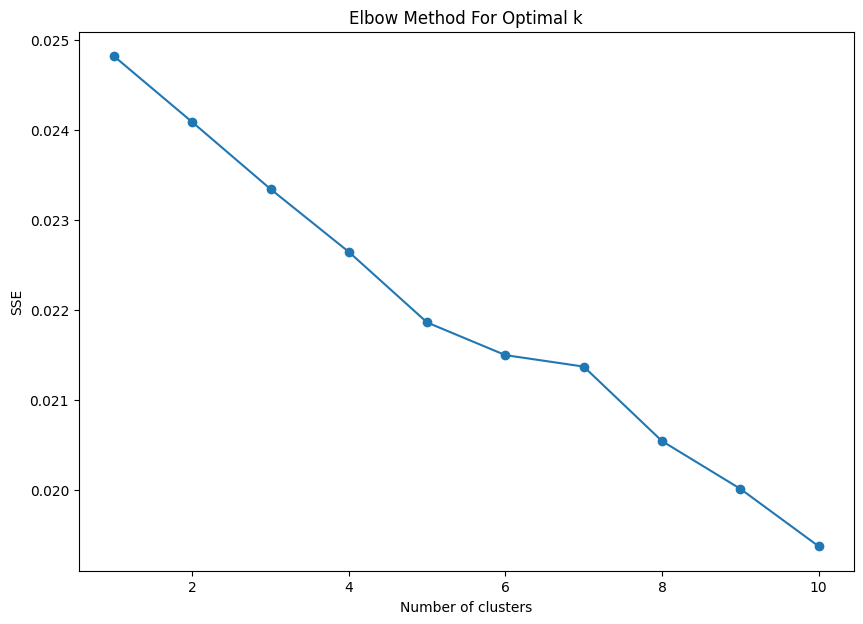

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Using the elbow method to find the optimal number of clusters
sse = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(vectors)
    sse.append(km.inertia_)

# Plotting the results on a line graph
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
# TSNE визуализация
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
vectors_2d_tsne = tsne.fit_transform(np.array(vectors))

# Plotly scatter plot of the clusters using t-SNE reduced vectors
fig_tsne = px.scatter(x=vectors_2d_tsne[:, 0], y=vectors_2d_tsne[:, 1], color=clusters,
                      labels={'x': 'Component 1', 'y': 'Component 2'}, title='2D Visualization of Text Clusters with t-SNE',
                      color_continuous_scale=px.colors.qualitative.Plotly, hover_data=[hover_data['Текст'], hover_data['id вопроса']])
fig_tsne.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



KeyError: 'текст вопроса'

# Реализуем выбор вопроса и исключение тех вопросов, которые ближе по кластеру

In [17]:
testquestions.to_excel('begin.xlsx')

In [19]:
import random
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

class QuestionBank:
    def __init__(self, questions):
        # Initializing the question bank with the provided dataframe of questions
        self.questions = questions
        print(f"Total number of questions in the bank: {len(self.questions)}") # Output the total number of questions at initialization
        
    def get_question_by_difficulty_and_topic(self, difficulty, topic):
        # Filtering questions by difficulty and modality (topic in this context)
        # Checking if there are any levels of difficulty within the specified topic
        difficulties_in_topic = self.questions[self.questions['Целевой орган'] == topic]['Сложность'].unique()
        if len(difficulties_in_topic) > 0:
            # If difficulty levels are present, selecting the smallest one
            lowest_difficulty = difficulties_in_topic.min()
            filtered_questions = self.questions[(self.questions['Сложность'] == lowest_difficulty) & (self.questions['Целевой орган'] == topic)]
        else:
            # If no questions match the difficulty and topic criteria, attempt selecting question from a new difficulty and topic
            alt_difficulty = random.choice(self.questions['ранг_сложности'].unique())
            alt_topic = random.choice(self.questions['Целевой орган'].unique())
            print(f"Trying alternative difficulty: {alt_difficulty} and topic: {alt_topic}")
            alt_filtered_questions = self.questions[(self.questions['Сложность'] == alt_difficulty) & (self.questions['Целевой орган'] == alt_topic)]
            if not alt_filtered_questions.empty:
                return alt_filtered_questions.sample().iloc[0]
        if not filtered_questions.empty:
            return filtered_questions.sample().iloc[0]
        return None

    def exclude_similar_questions(self, question_id, cluster_label):
        # Excluding questions from the same cluster
        excluded_questions = self.questions[(self.questions['cluster'] == cluster_label) & (self.questions.index != question_id)]
        
        print("Excluded Questions:")
        for index, row in excluded_questions.iterrows():
            print(f"Question ID: {index}, Difficulty: {row['Сложность']}, Cluster: {row['cluster']}, Question: {row['Текст']}")
        
        self.questions = self.questions[~(self.questions['cluster'] == cluster_label) & (self.questions.index != question_id)]

# Example student profile with preferences
student_profile = {"difficulty": 1, "topic": 3}

# Instance of QuestionBank with loaded questions
question_bank = QuestionBank(testquestions)

# Running 3 iterations as per instructions
for _ in range(3):
    if not question_bank.questions.empty:
        # Example of selecting a question based on student's difficulty and topic preference
        selected_question = question_bank.get_question_by_difficulty_and_topic(student_profile["difficulty"], student_profile["topic"])
        if selected_question is not None:
            print(f"Selected Question: ID: {selected_question.name}, Difficulty: {selected_question['Сложность']}, Cluster: {selected_question['cluster']}, Question: {selected_question['Текст']}")
            # After selecting a question, simulating excluding questions from the same cluster
            question_id = selected_question.name  # Assuming index of the dataframe serves as the question ID
            cluster_label = selected_question['cluster']
            question_bank.exclude_similar_questions(question_id, cluster_label)
        else:
            print("No more questions available that match the initial criteria. Attempting alternative difficulty and topic.")
            break
    else:
        print("Question Bank is empty.")
        break

    # Print the count of questions to verify exclusion
    print(f"Remaining questions count: {len(question_bank.questions)}")

Total number of questions in the bank: 99
Selected Question: ID: 33, Difficulty: 1, Cluster: 0, Question: Наиболее частым осложнением, сопровождающим нефроптоз с фиксированным перегибом мочеточника, является пиелонефрит гидронефроз уролитиаз сморщенная почка артериальная гипертензия
Excluded Questions:
Question ID: 19, Difficulty: 2, Cluster: 0, Question: Мужчина 30 лет, обратился с жалобами на повышенную температуру в течение 3-х недель и изнуряющий кашель, в последние дни - с прожилками крови, состояние средней степени тяжести. Лечился по месту жительства, получал антибиотикотерапию - без эффекта. Динамики в улучшении состояния не отмечает. Выполнена стандартная рентгенография органов грудной полости в двух проекциях. Ваше заключение? Левосторонняя полисегментарная пневмония в верхней и нижней доле Левосторонняя нижнедолевая пневмония Кавернозный туберкулез в нижней доле левого легкого
Question ID: 20, Difficulty: 2, Cluster: 0, Question: В клинику обратился пациент М. 80 лет, с жало

KeyError: 'ранг_сложности'

In [ ]:
#Предыдущий вариант. Ввожу возможность исключать вопросы на основе кластеров

import random
import statistics
from difflib import SequenceMatcher

class QuestionBank:
    def __init__(self, questions):
        # Initializing the question bank with a given list of questions
        self.questions = questions
        
    def get_question_by_difficulty_and_topic(self, difficulty, topic):
        # Filtering questions by difficulty and modality (topic in this context)
        # Checking if there are any levels of difficulty within the specified topic
        difficulties_in_topic = self.questions[self.questions['модальность_вопроса'] == topic]['ранг_сложности'].unique()
        if len(difficulties_in_topic) > 0:
            # If difficulty levels are present, selecting the smallest one
            lowest_difficulty = difficulties_in_topic.min()
            filtered_questions = self.questions[(self.questions['ранг_сложности'] == lowest_difficulty) & (self.questions['модальность_вопроса'] == topic)]
        else:
            # If no questions match the difficulty and topic criteria, attempt selecting question from a new difficulty and topic
            alt_difficulty = random.choice(self.questions['ранг_сложности'].unique())
            alt_topic = random.choice(self.questions['модальность_вопроса'].unique())
            print(f"Trying alternative difficulty: {alt_difficulty} and topic: {alt_topic}")
            alt_filtered_questions = self.questions[(self.questions['ранг_сложности'] == alt_difficulty) & (self.questions['модальность_вопроса'] == alt_topic)]
            if not alt_filtered_questions.empty:
                return alt_filtered_questions.sample().iloc[0]
        if not filtered_questions.empty:
            return filtered_questions.sample().iloc[0]
        return None

    def get_question_aligned_with_student_preference(self, student_profile):
        # Finding questions that align with the student's preferred topics or areas of strength at the beginning
        preferred_topics = student_profile.get('preferred_topics', [])
        if preferred_topics:
            aligned_questions = [question for question in self.questions if question['topic'] in preferred_topics]
            if aligned_questions:
                return random.choice(aligned_questions)
        # If no preference or no aligned questions found, return a medium difficulty question as fallback
        return self.get_medium_difficulty_question()

    def get_medium_difficulty_question(self):
        # Getting a medium difficulty question. If not available, find closest to median difficulty.
        medium_questions = [q for q in self.questions if q['difficulty'] == 'medium']
        if medium_questions:
            return random.choice(medium_questions)
        
        all_difficulties = [q['difficulty_level'] for q in self.questions]
        median_difficulty = statistics.median(all_difficulties)
        closest_to_median = min(self.questions, key=lambda q: abs(q['difficulty_level'] - median_difficulty))
        
        return closest_to_median

def initialize_student_model(student_profile):
    # Initializing the student model based on their profile
    student_model = {
        'current_difficulty': 'medium',  # Initial difficulty setting based on overall system design
        'answered_questions': {},  # Answers to questions
        'focus_areas': set(student_profile.get('preferred_topics', [])),  # Focus on preferred areas or strengths
    }
    return student_model

def select_initial_question(question_bank, student_profile):
    # Selecting an initial question based on student's preferred topics
    question = question_bank.get_question_aligned_with_student_preference(student_profile)
    return question

def update_student_model(student_model, question, is_correct, question_bank):
    # Updating the student model after answering a question
    if is_correct:
        # If correct, mark similar questions in the cluster as answered correctly to reinforce confidence
        student_model['answered_questions'][question['id']] = 'correct'
    else:
        # If incorrect, exclude similar questions from the same cluster for a diversified challenge
        student_model['answered_questions'][question['id']] = 'incorrect'

def get_next_question(question_bank, student_model):
    # Selecting the next question based on unanswered questions and focusing on reinforcing strengths
    unanswered_questions = [q for q in question_bank.questions if q['id'] not in student_model['answered_questions']]
    # Prioritize questions in focus areas if specified
    if student_model['focus_areas']:
        focus_questions = [q for q in unanswered_questions if q['topic'] in student_model['focus_areas']]
        if focus_questions:
            return random.choice(focus_questions)
    # If no unanswered questions in focus areas or none specified, return any unanswered question
    return random.choice(unanswered_questions) if unanswered_questions else None

def adaptive_testing_system(student_profile, question_bank):
    # Main function of the adaptive testing system
    student_model = initialize_student_model(student_profile)
    question = select_initial_question(question_bank, student_profile)
    
    while question:
        print(f"Question: {question['content']}")
        student_response = input("Enter your answer: ")
        is_correct = evaluate_response(question, student_response)
        print("Correct!" if is_correct else "Incorrect. Keep trying!")
        
        update_student_model(student_model, question, is_correct, question_bank)
        question = get_next_question(question_bank, student_model)
    
    print("Test completed. Calculating results...")

### Делаю симуляцию через catsim

### Сложный вариант с IRT тематикой, ML, DL -> колаборативной фильтрацией -> обновлением уровня способности студента -> обновлением сложности вопроса -> рекомендацией вопроса на основе вероятности. 

In [ ]:
#Модель 1. Предсказание сложности вопроса

from catboost import CatBoostRegressor
import pandas as pd

# Подготовка данных
# Загрузите или сгенерируйте ваш датасет здесь
data = pd.read_csv("path_to_your_dataset.csv")

# Разделяем данные на признаки и целевую переменную
X = data.drop('b', axis=1)
y = data['b']

# Деление данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

# Оценка модели
predictions = model.predict(X_test)

In [ ]:
#Модель 2. Предсказание вероятности ответа

from catboost import CatBoostClassifier

# Предположим, у нас уже есть датафрейм с историей ответов студентов
# и признаками, характеризующими студентов и вопросы

# Создание модели классификации, которая будет предсказывать вероятность правильного ответа
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=4, loss_function='Logloss')

# Обучение модели на данных о прошлых ответах
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

# Использование модели для предсказания подходящих вопросов
def recommend_questions(student_model, questions, model):
    probabilities = []
    for question in questions:
        features = create_features_for_question_and_student(question, student_model)
        prob = model.predict_proba(features)[0][1]  # Вероятность правильного ответа
        probabilities.append((question, prob))
    
    # Сортировка вопросов по убыванию вероятности правильного ответа
    sorted_questions = sorted(probabilities, key=lambda x: x[1], reverse=True)
    
    # Возвращаем список вопросов с наибольшей вероятностью правильного ответа
    return [q[0] for q in sorted_questions[:5]]


In [ ]:
#Класс вопрос

from math import exp

class Question:
    def __init__(self, id, topic, a=1.0, b=0.0, c=0.25, question_type="choice"):
        self.id = id
        self.topic = topic
        self.a = a  # Параметр дискриминации
        self.b = b  # Параметр сложности
        self.c = c  # Параметр угадывания
        self.question_type = question_type

    def calculate_probability_of_correct_answer(self, student_ability):
        """Вычисляет вероятность правильного ответа на вопрос студентом с заданной способностью."""
        try:
            return self.c + (1 - self.c) / (1 + exp(-self.a * (student_ability - self.b)))
        except OverflowError:
            # Если способность студента значительно превышает b, предотвращаем переполнение
            return 1.0 if student_ability > self.b else 0.0

    def is_appropriate_for_student(self, student_model):
        """Определяет, подходит ли вопрос студенту, основываясь на его способностях и профиле."""
        student_ability = student_model.abilities_by_topic.get(self.topic, student_model.general_ability)
        probability = self.calculate_probability_of_correct_answer(student_ability)
        # Вопрос считается подходящим, если вероятность правильного ответа находится в приемлемом диапазоне
        return 0.25 < probability < 0.75

    # Предполагаемая функция для обновления параметров вопроса на основе ответов студентов
    def update_parameters_based_on_responses(self, responses):
        """Обновляет параметры вопроса на основе ответов студентов.
           Это упрощенный пример. В реальности процесс обновления будет включать сложные вычисления."""
        pass

In [ ]:
#Класс Студент. Ввожу вес вопроса и профиль студента 

from datetime import datetime

class StudentModel:
    def __init__(self, initial_ability, initial_topics_ability=None):
        self.general_ability = initial_ability
        self.abilities_by_topic = initial_topics_ability if initial_topics_ability is not None else {}
        self.history = []

    def update_general_ability(self, adjustment):
        self.general_ability += adjustment

    def update_topic_ability(self, question, is_correct):
        topic = question.topic
        question_weight = self._calculate_question_weight(question.b)  # Исправлено на question.b
        sequence_adjustment = self._analyze_answer_sequence(is_correct, topic)

        adjustment = self._adjustment_factor(question.b, is_correct, question_weight) * sequence_adjustment  # Исправлено на question.b
        adjustment = min(max(adjustment, -0.1), 0.1)

        if topic not in self.abilities_by_topic:  # Исправлено на правильную логику
            self.abilities_by_topic[topic] = self.general_ability
        self.abilities_by_topic[topic] += adjustment

        self.general_ability += adjustment * 0.1

        self.history.append({'id': question.id, 'topic': topic, 'is_correct': is_correct, 'time': datetime.now(), 'adjustment': adjustment})

    def _analyze_answer_sequence(self, is_correct, topic):
        topic_history = [h for h in self.history if h['topic'] == topic][-3:]  # История ответов по теме
        if len(topic_history) < 3:
            return 1.0

        last_answers = [h['is_correct'] for h in topic_history] + [is_correct]
        if all(last_answers):
            return 1.2
        elif not any(last_answers):
            return 0.8
        else:
            return 1.0

    def _calculate_question_weight(self, question):
        difficulty_weight = {'easy': 0.5, 'medium': 1.0, 'hard': 1.5}
        rarity_weight = 1.0  # Для примера; в реальности следует динамически вычислять
        return difficulty_weight.get(question['difficulty'], 1) * rarity_weight


    def _adjustment_factor(self, difficulty, is_correct, question_weight):
        base_adjustment = 0.05
        difficulty_multiplier = {'easy': 0.8, 'medium': 1.0, 'hard': 1.2}.get(difficulty, 1.0)
        return base_adjustment * difficulty_multiplier * question_weight



In [ ]:
class AdaptiveTestSystem:
    def __init__(self, questions, student_model):
        self.questions = questions
        self.student_model = student_model
        self.question_difficulty_model = None  # Модель для предсказания сложности вопроса
        self.answer_probability_model = None  # Модель для предсказания вероятности ответа

    def train_models(self, questions_data, answers_data):
        # Обучение модели сложности вопроса
        X_questions = questions_data.drop(['b'], axis=1)
        y_questions = questions_data['b']
        self.question_difficulty_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=4)
        self.question_difficulty_model.fit(X_questions, y_questions, verbose=False)
        
        # Обучение модели вероятности ответа
        X_answers = answers_data.drop(['is_correct'], axis=1)
        y_answers = answers_data['is_correct']
        self.answer_probability_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=4, loss_function='Logloss')
        self.answer_probability_model.fit(X_answers, y_answers, verbose=False)

    def predict_question_difficulty(self, question_features):
        # Предсказание сложности вопроса
        return self.question_difficulty_model.predict(question_features)

    def recommend_questions(self, student_features):
        # Рекомендация вопросов на основе предсказания вероятности правильного ответа
        probabilities = []
        for question in self.questions:
            # Создаем признаки для вопроса и студента напрямую в этом методе
            # Например, используем общую способность студента и сложность вопроса как признаки
            features = [student_features.general_ability, question.b]
            prob = self.answer_probability_model.predict_proba([features])[0][1]  # Вероятность правильного ответа
            probabilities.append((question, prob))
        
        # Сортировка вопросов по убыванию вероятности правильного ответа
        sorted_questions = sorted(probabilities, key=lambda x: x[1], reverse=True)
        
        # Возвращаем список вопросов с наибольшей вероятностью правильного ответа
        return [q[0] for q in sorted_questions[:5]]

    def select_question(self):
        probabilities = []
        for question in self.questions:
            features = self.create_features_for_question(question, self.student_model)
            prob = self.answer_probability_model.predict_proba([features])[0][1]
            probabilities.append((question, prob))
        sorted_questions = sorted(probabilities, key=lambda x: x[1], reverse=True)
        return sorted_questions[0][0] if sorted_questions else None
    
    def update_student_model(self, question_id, is_correct):
        question = next((q for q in self.questions if q.id == question_id), None)
        if question:
            self.student_model.update_topic_ability(question, is_correct)
            # Если есть модель для предсказания сложности вопроса, используйте ее для обновления b
            if self.question_difficulty_model:
                features_for_difficulty = self.create_features_for_difficulty_update(question, is_correct)
                new_b = self.question_difficulty_model.predict([features_for_difficulty])[0]
                question.b = new_b  # Обновляем сложность вопроса

In [ ]:
# Первым делом установим необходимые библиотеки
!pip install catsim matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [23]:
from catsim.cat import generate_item_bank
from catsim.simulation import *
from catsim.initialization import *
from catsim.selection import *
from catsim.estimation import *
from catsim.stopping import *
import catsim.plot as catplot
from catsim.irt import icc
import numpy as np
import random
import matplotlib.pyplot as plt

# Генерируем банк вопросов
items = generate_item_bank(100)

# Создаем селектор, который будет выбирать вопросы из кластеров
clusters = np.random.randint(0, 5, size=100) # Присваиваем каждому вопросу случайный кластер от 0 до 4
selector = ClusterSelector(clusters=clusters, method='item_info', r_max=1, r_control='passive')

# Показать сгенерированный банк вопросов и кластеры
items, clusters

(array([[ 1.4337247 , -0.52579539,  0.2681737 ,  0.95367379],
        [ 1.2287792 , -0.26677113,  0.27539403,  0.99287674],
        [ 1.12233399,  0.17487073,  0.26444748,  0.96049841],
        [ 1.29541943,  0.1403382 ,  0.29568112,  0.96186786],
        [ 0.74742233,  0.56846538,  0.26657997,  0.98061089],
        [ 0.81286852, -2.15046728,  0.26833951,  0.94690551],
        [ 1.09912089,  0.12719243,  0.26803329,  0.9926802 ],
        [ 1.40258731, -0.24493756,  0.24346377,  0.9771476 ],
        [ 1.16861396,  0.92506523,  0.22060399,  0.95377546],
        [ 1.37147459, -1.12596154,  0.23954649,  0.99188643],
        [ 1.16241612,  0.04097181,  0.24535207,  0.9987524 ],
        [ 1.38793946,  0.46740462,  0.2789079 ,  0.98525932],
        [ 1.15456134,  0.25518121,  0.26654765,  0.94365089],
        [ 1.4934766 ,  1.87127711,  0.24865686,  0.96416544],
        [ 1.15217904,  1.64404159,  0.26728135,  0.95971179],
        [ 0.9796599 , -0.39411875,  0.24713705,  0.97786211],
        

In [ ]:
# Начальная инициализация способности экзаменуемого
initializer = FixedPointInitializer(0)
est_theta = initializer.initialize()

# Выбор следующего вопроса из кластера
item_index = selector.select(items=items, administered_items=[], est_theta=est_theta)

# Вероятность правильного ответа на выбранный вопрос
true_theta = 0.8 # предположим, что реальная способность экзаменуемого равна 0.8
a, b, c, d = items[item_index]
prob = icc(true_theta, a, b, c, d)

# Вывод информации о выбранном вопросе и вероятности правильного ответа
item_index, prob

/root/venv/lib/python3.9/site-packages/catsim/selection.py:444: UserWarning:

This selector needs an item matrix with at least 5 columns, with the last one representing item exposure rate. Since this column is absent, it will presume all items have exposure rates = 0



(7, 0.8663695000879332)

In [ ]:
!pip install catsim==0.17.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 50.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [21]:
!pip install catsim==0.17.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 26.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [27]:
from catsim.selection import ClusterSelector
import numpy as np

# Получаем данные о кластерах из датафрейма
testquestions_clusters = testquestions['cluster'].values

# Создаем матрицу элементов с дополнительной колонкой, обозначающей степень использования вопроса (item exposure rate)
# Указываем, что все вопросы имеют степень использования 0, как требуется в предупреждении
# В этой симуляции используем подставные значения для параметров вопроса, так как они не располагаются в тестовом датафрейме
# Предполагаем, что параметры 'a', 'b', 'c', 'd' не доступны, поэтому используем заглушки
item_exposure_rates = np.zeros((len(testquestions), 1))  # Создаем колонку со степенью использования вопроса равной 0

# Заглушка для примера. В вашем случае вам нужно заменить это на реальные значения, если они доступны.
items_parameters_placeholder = np.random.rand(len(testquestions), 4)  # Создаем случайные параметры вопроса

items_with_exposure = np.hstack((items_parameters_placeholder, item_exposure_rates))  # Добавляем эту колонку к параметрам вопросов

# Создаем селектор, который будет выбирать вопросы из кластеров
selector = ClusterSelector(clusters=testquestions_clusters, method='item_info', r_max=1, r_control='passive')

# Начальная инициализация способности экзаменуемого
initializer = FixedPointInitializer(0)
est_theta = initializer.initialize()

# Выбор следующего вопроса из кластера
item_index = selector.select(items=items_with_exposure, administered_items=[], est_theta=est_theta)

# Получаем текст выбранного вопроса
selected_question_text = testquestions.iloc[item_index]['Текст']

selected_question_text

'Для искусственного контрастирования в рентгенологии применяются сульфат бария, органические соединения йода, газы (кислород, закись азота, углекислый газ), все перечисленное '

In [28]:
# Исправление: Рассчитаем информативность только для вопросов, которые присутствуют в датафрейме
testquestions['informative'] = np.nan

# Предполагаем, что у нас есть соответствие между индексами вопросов в датафрейме и их параметрами в items
# Так как у нас нет прямого соответствия, мы будем использовать первые 99 элементов из items для примера
theta = 0
informative_values = inf_hpc(theta, items[:99])

# Добавляем информативность как новую колонку в датафрейм
testquestions['informative'] = informative_values

# Выводим обновленный датафрейм
testquestions.head()

NameError: name 'inf_hpc' is not defined

In [29]:
from catsim.selection import ClusterSelector
from catsim.stopping import MaxItemStopper
from catsim.initialization import RandomInitializer
from catsim.estimation import NumericalSearchEstimator
from catsim.selection import MaxInfoSelector
from catsim.simulation import Simulator
import numpy as np
import pandas as pd

# Подготовка данных
# Преобразование DataFrame в numpy array для использования с catsim
# Модификация: Добавление дополнительных параметров для items_parameters, чтобы иметь форму, ожидаемую catsim (a, b, c, d)
testquestions = pd.DataFrame({'informative': np.random.rand(100), 'cluster': np.random.randint(0, 5, size=100)}) # Генерация тестовых данных
a = np.full((len(testquestions), 1), 1)  # предполагаем, что все вопросы имеют дискриминацию 1
b = testquestions[['informative']].values  # 'b' параметр, изначально идентифицированный как 'informative'
c = np.full((len(testquestions), 1), 0.25)  # предполагаем, что все вопросы имеют параметр угадывания 0.25
d = np.full((len(testquestions), 1), 1)  # предполагаем, что все вопросы имеют псевдопараметр d равный 1
items_parameters = np.hstack((a, b, c, d))  # составляем матрицу параметров вопросов

clusters = testquestions['cluster'].values

# Определение селектора
selector = ClusterSelector(clusters=clusters, method='item_info', r_max=1, r_control='passive')

# Определение количества вопросов в каждом кластере
unique_clusters, counts = np.unique(clusters, return_counts=True)
max_items = counts.sum()

# Определение стоппера
stopper = MaxItemStopper(max_itens=max_items)

# Создание симулятора
s = Simulator(items_parameters, 10, RandomInitializer(), selector, NumericalSearchEstimator(), stopper)

# Запуск симуляции
s.simulate(verbose=True)

# Вывод результатов
bias = s.bias
mse = s.mse
rmse = s.rmse
examinee_index = 0
true_proficiency = s.examinees[examinee_index]
items_administered = s.administered_items[examinee_index]
responses = s.response_vectors[examinee_index]
estimations = s.estimations[examinee_index]

bias, mse, rmse, true_proficiency, items_administered, responses, estimations


Starting simulation: Random Initializer Cluster Selector Numerical Search Estimator (bounded) Maximum Item Number Initializer 100 items
100%|██████████| 10/10 [00:02<00:00,  3.37it/s]Simulation took 2.9633450508117676 seconds



(-0.09841206772062182,
 0.08232478633546227,
 0.2869229623704981,
 0.9277909232002091,
 [45,
  15,
  23,
  41,
  48,
  33,
  36,
  70,
  96,
  83,
  21,
  25,
  94,
  61,
  66,
  87,
  3,
  12,
  18,
  8,
  95,
  31,
  80,
  5,
  68,
  88,
  47,
  53,
  46,
  99,
  34,
  93,
  81,
  30,
  16,
  2,
  35,
  42,
  77,
  32,
  60,
  50,
  90,
  49,
  98,
  11,
  9,
  57,
  74,
  17,
  67,
  22,
  97,
  13,
  76,
  19,
  26,
  78,
  6,
  52,
  20,
  38,
  89,
  62,
  84,
  28,
  44,
  39,
  55,
  59,
  91,
  79,
  29,
  43,
  58,
  69,
  71,
  1,
  7,
  73,
  82,
  37,
  54,
  4,
  51,
  86,
  56,
  27,
  14,
  24,
  10,
  92,
  63,
  85,
  64,
  75,
  40,
  72,
  65,
  0],
 [True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,

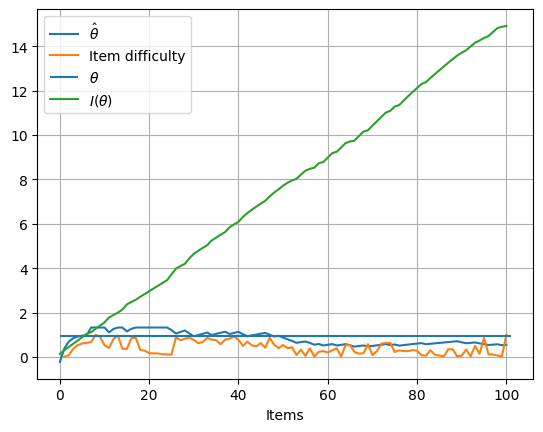

In [30]:
catplot.test_progress(simulator=s,index=0, info=True)

Произошла ошибка, связанная с отсутствием кол

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9349f80f-e3a6-4f6f-8e4c-025313d5eb81' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>